<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`is_fraudulent`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:

| Columna               | Descripción                                                                                     |
|-----------------------|-------------------------------------------------------------------------------------------------|
| `transaction_id`      | Identificador único de la transacción.                                                         |
| `customer_id`         | Identificador único del cliente que realizó la transacción.                                    |
| `merchant_id`         | Identificador único del comercio donde se realizó la transacción.                              |
| `amount`              | Monto de la transacción (en la moneda correspondiente).                                        |
| `transaction_time`    | Fecha y hora exacta en la que ocurrió la transacción.                                          |
| `is_fraudulent`       | Indicador de si la transacción fue fraudulenta (1: Sí, 0: No).                                 |
| `card_type`           | Tipo de tarjeta utilizada para la transacción (Visa, MasterCard, American Express, Discover).  |
| `location`            | Ubicación (ciudad o región) donde se realizó la transacción.                                   |
| `purchase_category`   | Categoría de la compra (por ejemplo, Gas Station, Online Shopping, Retail, etc.).              |
| `customer_age`        | Edad del cliente en el momento de la transacción.                                              |
| `transaction_description` | Descripción breve de la transacción, usualmente incluye el comercio asociado.              |


____________________________________________________

## **Análisis Exploratorio de Datos (EDA)**

In [67]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math
import pickle

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor


# Para tratar el problema de desbalance
# -----------------------------------------------------------------------
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from scipy.stats import chi2_contingency

import sys
import os
import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath('../'))
from src import funciones_eda as fs
from src import funciones_gestion_nulos as fgn
from src import funciones_outliers as fo
from src import funciones_encoding as fe
from src import funciones_estandarizacion as fes



In [36]:
df = pd.read_csv("../datos/financial_data.csv")

# Pasamos la VR a categorica 
df["is_fraudulent"]=df["is_fraudulent"].astype("object")
print(df.shape)
df.sample(2)

(10000, 11)


transaction_id  customer_id  merchant_id   amount     transaction_time  \
2419            2420         1023         2037  6699.63  2023-01-01 00:40:19   
7581            7582         1082         2033  8727.34  2023-01-01 02:06:21   

     is_fraudulent card_type location purchase_category  customer_age  \
2419             1  Discover  City-33         Groceries            48   
7581             1      Visa  City-35        Restaurant            61   

        transaction_description  
2419  Purchase at Merchant-2037  
7581  Purchase at Merchant-2033

In [37]:
fs.exploracion_dataframe(df)

El número de datos es 10000 y el de columnas es 11

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


Empty DataFrame
Columns: [%_nulos]
Index: []


 ..................... 

Los tipos de las columnas son:


tipo_dato
transaction_id              int64
customer_id                 int64
merchant_id                 int64
amount                    float64
transaction_time           object
is_fraudulent              object
card_type                  object
location                   object
purchase_category          object
customer_age                int64
transaction_description    object


 ..................... 



count         mean          std      min       25%  \
transaction_id  10000.0  5000.500000  2886.895680     1.00  2500.750   
customer_id     10000.0  1051.272300    28.864062  1001.00  1026.000   
merchant_id     10000.0  2050.486600    28.877801  2001.00  2025.000   
amount          10000.0  4958.381617  2899.699675    10.61  2438.175   
customer_age    10000.0    44.047500    15.321707    18.00    31.000   

                     50%        75%       max  
transaction_id  5000.500  7500.2500  10000.00  
customer_id     1052.000  1076.0000   1100.00  
merchant_id     2050.000  2076.0000   2100.00  
amount          4943.945  7499.3125   9999.75  
customer_age      44.000    57.0000     70.00


 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna TRANSACTION_TIME tiene las siguientes valore únicos:


count
transaction_time          
2023-01-01 02:46:23      1
2023-01-01 02:46:22      1
2023-01-01 02:46:21      1
2023-01-01 02:46:20      1
2023-01-01 02:46:19      1

La columna IS_FRAUDULENT tiene las siguientes valore únicos:


count
is_fraudulent       
1               5068
0               4932

La columna CARD_TYPE tiene las siguientes valore únicos:


count
card_type              
Discover           2633
American Express   2494
Visa               2490
MasterCard         2383

La columna LOCATION tiene las siguientes valore únicos:


count
location       
City-7      223
City-40     221
City-14     218
City-32     218
City-41     218

La columna PURCHASE_CATEGORY tiene las siguientes valore únicos:


count
purchase_category       
Travel              1694
Groceries           1692
Gas Station         1666
Retail              1661
Online Shopping     1651

La columna TRANSACTION_DESCRIPTION tiene las siguientes valore únicos:


count
transaction_description         
Purchase at Merchant-2016    120
Purchase at Merchant-2078    120
Purchase at Merchant-2055    118
Purchase at Merchant-2019    117
Purchase at Merchant-2057    117

- Tenemos 10000 filas y 11 columnas.
- No hay duplicados ni nulos.

- La columna transaction id que identifica cada una de las filas no va a ser de ayuda para predecir pues cada columna tiene un transaction id distinto por lo que la dropeamos.

- La columna fecha son todas del mismo día y la hora va cambiando, cada segundo es una transacción, por lo que al ser un dato distinto para cada columna no nos aporta ningún tipo de valor y además es raro que cada transacción sea en un segundo distinto todas en el mismo dia por lo que también puede ser un dato erróneo, la quitamos.

- Amount va desde 10 hasta 9999.75 por lo que parece haber un tope de 10000 para realizar una transferencia.

- La columna transaction_description coincide con merchant_id por lo que es un dato redundante que podemos eliminar.


In [38]:
df.drop(columns=["transaction_id", "transaction_time", "transaction_description"], inplace=True)

### 1. Visualizar numéricas y categóricas.

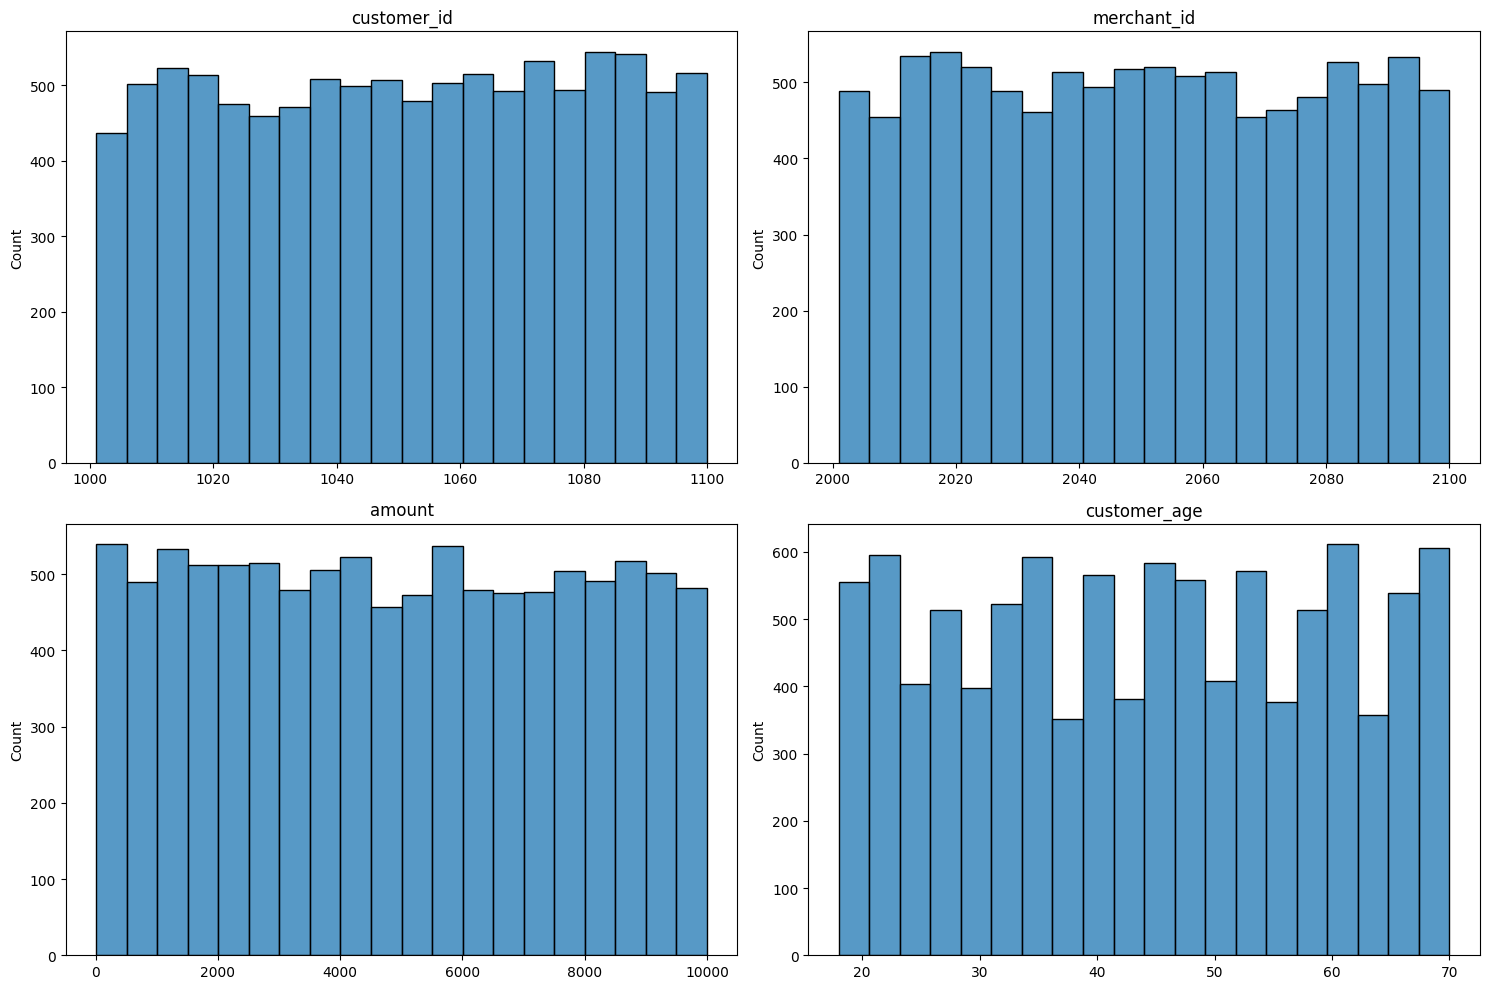

In [39]:
df_num, df_cat = fs.separar_df(df)
fs.plot_numericas(df_num, bins=20)

- Aunque parezcan numéricas tanto customer_id como merchant_id son categoricas ya que son una etiqueta identificativa. Vamos a probar a ponerlas como categoricas y esperar que haya diferencias significativas para no tener que hacer el one hot encoder, si fuera asi la tratariamos como numérica.

- La cantidad esta bastante distribuida, no parece haber outliers.

In [40]:
df[["customer_id", "merchant_id"]] = df[["customer_id", "merchant_id"]].astype("object")

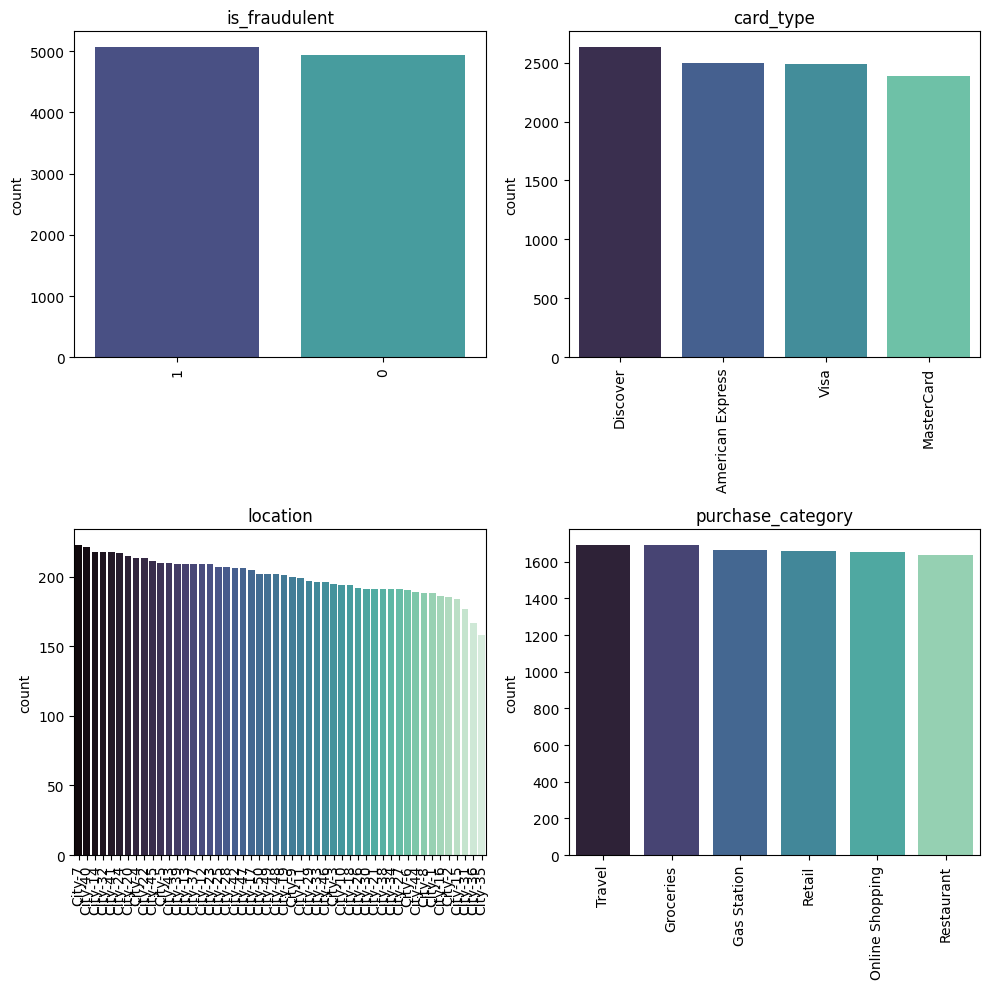

In [41]:
fs.plot_categoricas(df_cat, figsize=(10, 10))

- A simple vista podemos ver que no parece haber desbalanceo.
- Para purchase_category parece no haber diferencias significativas entre las variables, en las de card_type habría que comprobarlo. Y esperemos que haya diferencia para location.


### 2. Visualizar la relación de las numéricas y categóricas con la variable respuesta.

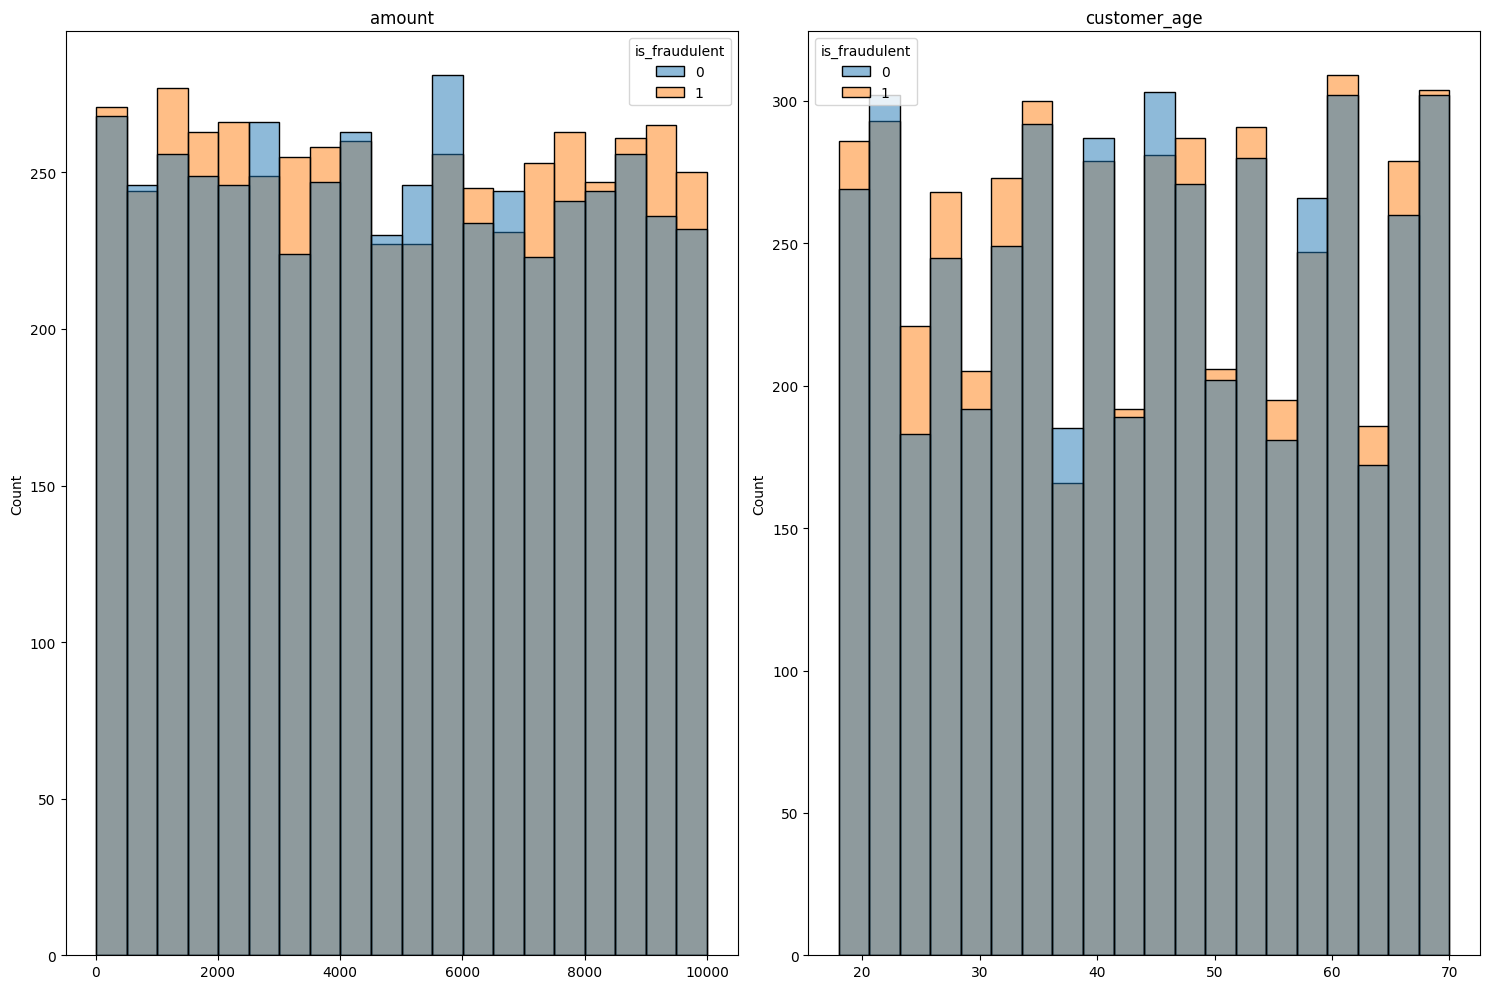

In [42]:
fs.relacion_vr_numericas_problema_categorico(df, "is_fraudulent")

Es complicado ver un patrón general, en cuanto a la cantidad de la transacción es cierto que para transacciones mayores de 7000 tiende a haber más fraudulentas. En cuanto a la edad de los clientes vavariando, pero si que hay un grupo de edad donde se realizan más transacciones fraudulentas que normales y es sobre los 25, aunque son pocas en comparación con el resto de edades.

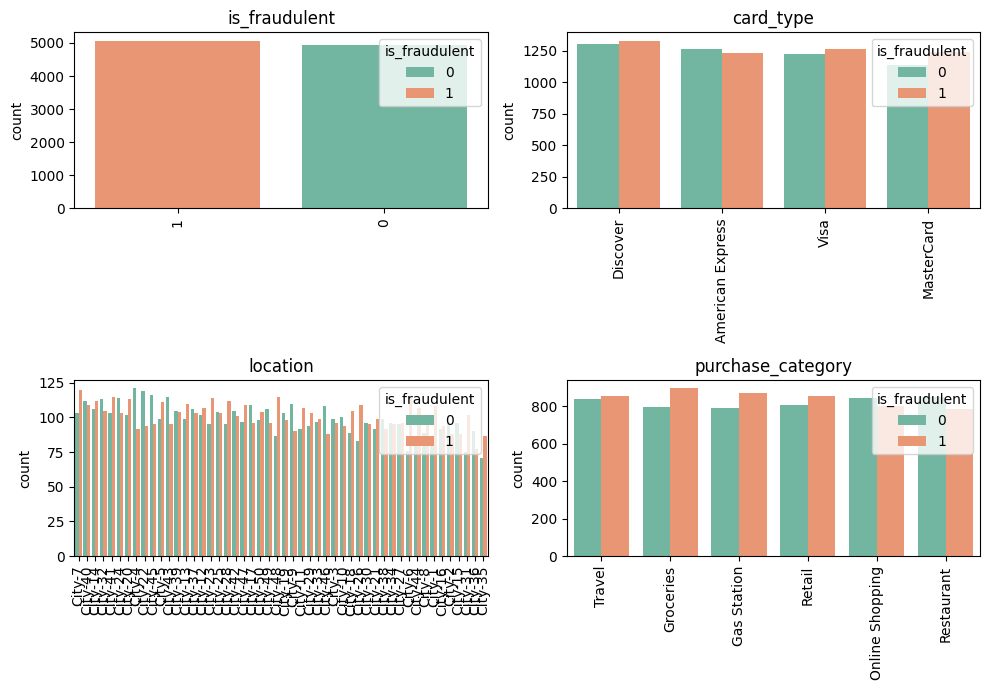

In [43]:
fs.relacion_vr_categoricas_problema_categorico(df_cat, "is_fraudulent", figsize=(10,7))

- Para purchase_category es bastante parecido las compras fraudulentas y no fraudulentas, sin embargo para Travel, Groceries, Gas y Retail hay más transacciones fraudulentas que normales.
- Veamos con la tabla de contingencia si hay diferencias significativas entre las variblas de las categoricas en cuanto a la VR:

In [44]:
vr = "is_fraudulent"
fs.detectar_orden_problema_categorico(df, vr)

Estamos comparando las variables de CUSTOMER_ID
El p-valor es 0.8012597537846581
La variable CUSTOMER_ID NO tiene orden ❌

---------------------------------------------

Estamos comparando las variables de MERCHANT_ID
El p-valor es 0.6912371762337386
La variable MERCHANT_ID NO tiene orden ❌

---------------------------------------------

Estamos comparando las variables de CARD_TYPE
El p-valor es 0.2860795035131719
La variable CARD_TYPE NO tiene orden ❌

---------------------------------------------

Estamos comparando las variables de LOCATION
El p-valor es 0.18154121719730704
La variable LOCATION NO tiene orden ❌

---------------------------------------------

Estamos comparando las variables de PURCHASE_CATEGORY
El p-valor es 0.020791075460818625
La variable PURCHASE_CATEGORY SÍ tiene orden ✅

---------------------------------------------



### 3. Correlación entre variables numéricas

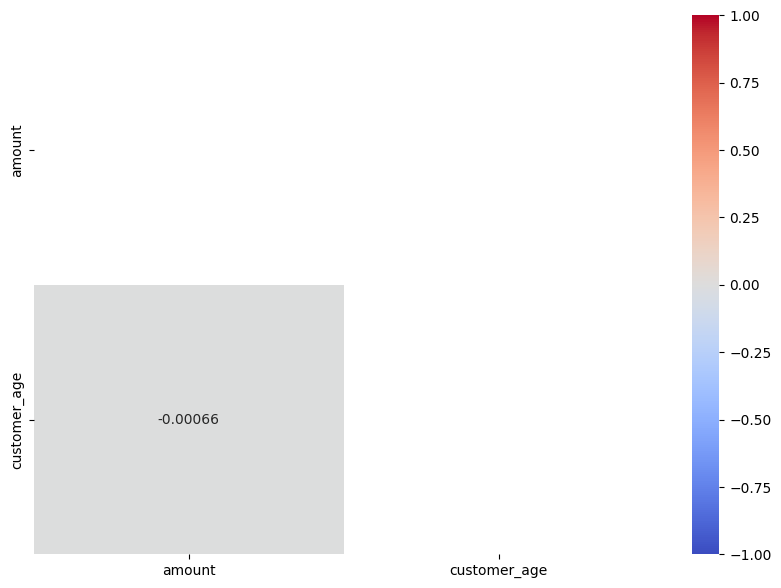

In [45]:
fs.heatmap_correlacion(df)

Las únicas variable numéricas que tenemos no tienen ningún tipo de correlación.

### 4. Outliers

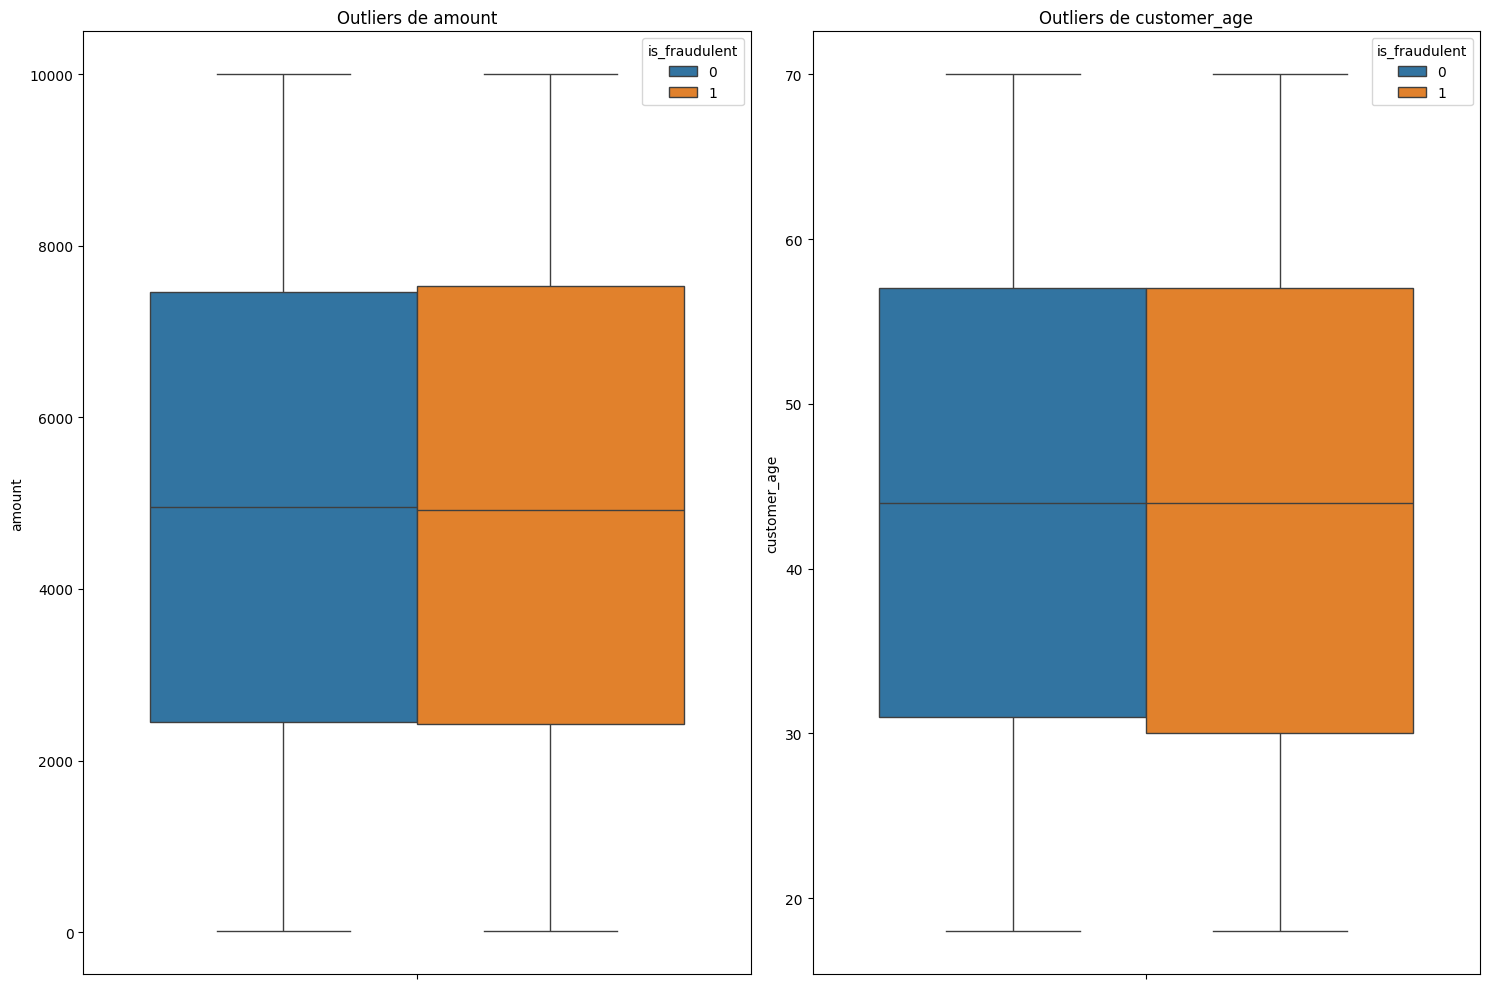

In [46]:
fs.detectar_outliers_problema_clasificacion(df,vr, figsize=(15,10), rotate=False)

No parece haber ningún outlier univariado.

# **Gestión de nulos**

In [47]:
df.isna().sum()

customer_id          0
merchant_id          0
amount               0
is_fraudulent        0
card_type            0
location             0
purchase_category    0
customer_age         0
dtype: int64

No hay nulos, todos contentos :)

In [49]:
with open('../datos/df_nonulls.pkl', 'wb') as f:
    pickle.dump(df, f)

# **Encoding**

In [41]:
with open('../datos/df_nonulls.pkl', 'rb') as f:
    df = pickle.load(f)
df.head()

customer_id merchant_id   amount is_fraudulent   card_type location  \
0        1082        2027  5758.59             0  MasterCard  City-30   
1        1015        2053  1901.56             1        Visa  City-47   
2        1004        2035  1248.86             1  MasterCard   City-6   
3        1095        2037  7619.05             1    Discover   City-6   
4        1036        2083  1890.10             1  MasterCard  City-34   

  purchase_category  customer_age  
0       Gas Station            43  
1   Online Shopping            61  
2       Gas Station            57  
3            Travel            59  
4            Retail            36

In [42]:
df.dtypes

customer_id           object
merchant_id           object
amount               float64
is_fraudulent         object
card_type             object
location              object
purchase_category     object
customer_age           int64
dtype: object

In [43]:
vr = "is_fraudulent"
fs.detectar_orden_problema_categorico(df, vr)

Estamos comparando las variables de CUSTOMER_ID
El p-valor es 0.8012597537846581
La variable CUSTOMER_ID NO tiene orden ❌

---------------------------------------------

Estamos comparando las variables de MERCHANT_ID
El p-valor es 0.6912371762337386
La variable MERCHANT_ID NO tiene orden ❌

---------------------------------------------

Estamos comparando las variables de CARD_TYPE
El p-valor es 0.2860795035131719
La variable CARD_TYPE NO tiene orden ❌

---------------------------------------------

Estamos comparando las variables de LOCATION
El p-valor es 0.18154121719730704
La variable LOCATION NO tiene orden ❌

---------------------------------------------

Estamos comparando las variables de PURCHASE_CATEGORY
El p-valor es 0.020791075460818625
La variable PURCHASE_CATEGORY SÍ tiene orden ✅

---------------------------------------------



Como hemos vitso solo tiene orden PURCHASE_CATEGORY, sin embargo es inviable hacer un one hot encding para CUSTOMER_ID, MERCHANT_ID o  LOCATION ya que tienen muchísimos valores distintos y generaríamos una columna por cada variable. Por lo que usaremos un target encoder para PURCHASE_CATEGORY, CUSTOMER_ID, MERCHANT_ID y LOCATION, y one-hot encoding en CARD_TYPE.

In [44]:
# Tenemos que pasar la VR a numerica ya que sino el target encoder no funciona si la VR es una categórica
df["is_fraudulent"] = df["is_fraudulent"].astype("int")

In [45]:
diccionario_encoding={"target":["customer_id", "merchant_id", "location", "purchase_category"], "onehot":['card_type']}
var_respuesta = "is_fraudulent"
encoding = fe.Encoding(df, diccionario_encoding, var_respuesta)

In [46]:
df_ohe, one_hot_encoder = encoding.one_hot_encoding()
df_ohe.drop(columns=["card_type"], inplace=True)
df_ohe.head()

customer_id merchant_id   amount  is_fraudulent location purchase_category  \
0        1082        2027  5758.59              0  City-30       Gas Station   
1        1015        2053  1901.56              1  City-47   Online Shopping   
2        1004        2035  1248.86              1   City-6       Gas Station   
3        1095        2037  7619.05              1   City-6            Travel   
4        1036        2083  1890.10              1  City-34            Retail   

   customer_age  card_type_American Express  card_type_Discover  \
0            43                         0.0                 0.0   
1            61                         0.0                 0.0   
2            57                         0.0                 0.0   
3            59                         0.0                 1.0   
4            36                         0.0                 0.0   

   card_type_MasterCard  card_type_Visa  
0                   1.0             0.0  
1                   0.0             1.0  
2                   1.0             0.0  
3                   0.0             0.0  
4                   1.0             0.0

In [47]:
df_ohe_target, target_encoder = encoding.target_encoding()
df_ohe_target.head(3)

is_fraudulent  customer_id  merchant_id   amount  location  \
0              0     0.540537     0.517856  5758.59  0.497382   
1              1     0.543680     0.536825  1901.56  0.529126   
2              1     0.586109     0.506026  1248.86  0.600000   

   purchase_category  customer_age  card_type_American Express  \
0           0.524610            43                         0.0   
1           0.486978            61                         0.0   
2           0.524610            57                         0.0   

   card_type_Discover  card_type_MasterCard  card_type_Visa  
0                 0.0                   1.0             0.0  
1                 0.0                   0.0             1.0  
2                 0.0                   1.0             0.0

In [48]:
df_ohe_target["is_fraudulent"] = df_ohe_target["is_fraudulent"].astype("object")

In [49]:
with open('../datos/df_nonulls_encoded.pkl', 'wb') as f:
    pickle.dump(df_ohe_target, f)

# **Gestión de outliers**

In [50]:
with open('../datos/df_nonulls_encoded.pkl', 'rb') as f:
    df = pickle.load(f)
df.head()

is_fraudulent  customer_id  merchant_id   amount  location  \
0             0     0.540537     0.517856  5758.59  0.497382   
1             1     0.543680     0.536825  1901.56  0.529126   
2             1     0.586109     0.506026  1248.86  0.600000   
3             1     0.543680     0.525765  7619.05  0.600000   
4             1     0.470012     0.523806  1890.10  0.497382   

   purchase_category  customer_age  card_type_American Express  \
0           0.524610            43                         0.0   
1           0.486978            61                         0.0   
2           0.524610            57                         0.0   
3           0.505313            59                         0.0   
4           0.513546            36                         0.0   

   card_type_Discover  card_type_MasterCard  card_type_Visa  
0                 0.0                   1.0             0.0  
1                 0.0                   0.0             1.0  
2                 0.0                   1.0             0.0  
3                 1.0                   0.0             0.0  
4                 0.0                   1.0             0.0

In [51]:
df.dtypes

is_fraudulent                  object
customer_id                   float64
merchant_id                   float64
amount                        float64
location                      float64
purchase_category             float64
customer_age                    int64
card_type_American Express    float64
card_type_Discover            float64
card_type_MasterCard          float64
card_type_Visa                float64
dtype: object

In [52]:
univariados = fo.GestionOutliersUnivariados(df)
diccionario_iqr = univariados.detectar_outliers_iqr()

La cantidad de outliers que tenemos para la columna CUSTOMER_ID es 193
La cantidad de outliers que tenemos para la columna MERCHANT_ID es 295
La cantidad de outliers que tenemos para la columna CARD_TYPE_AMERICAN EXPRESS es 2494
La cantidad de outliers que tenemos para la columna CARD_TYPE_MASTERCARD es 2383
La cantidad de outliers que tenemos para la columna CARD_TYPE_VISA es 2490


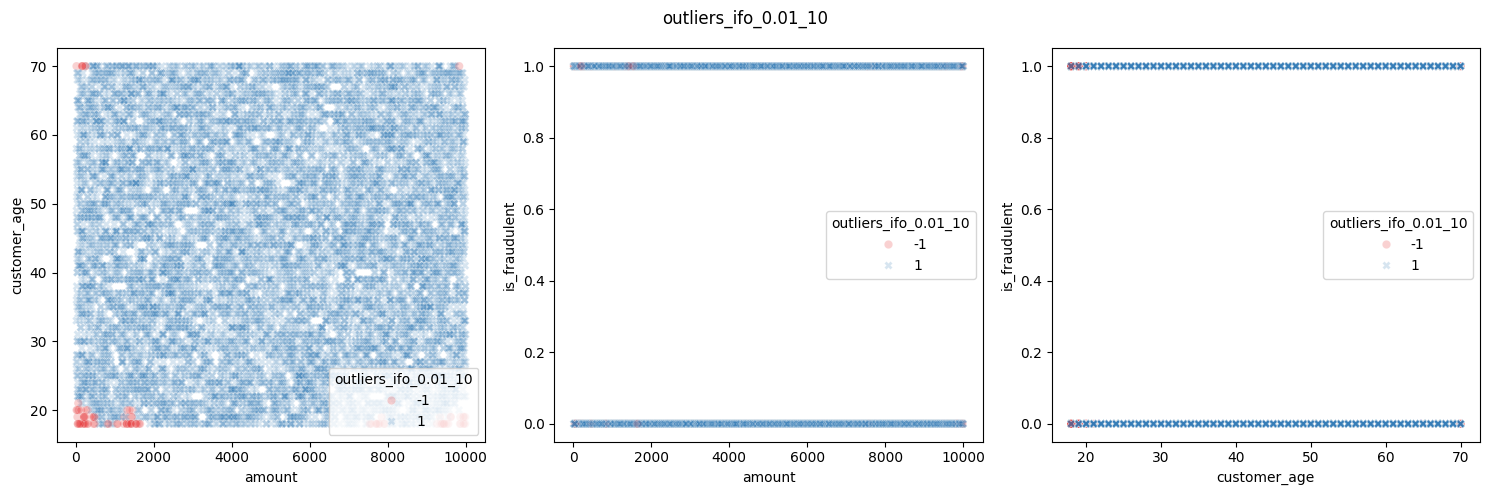

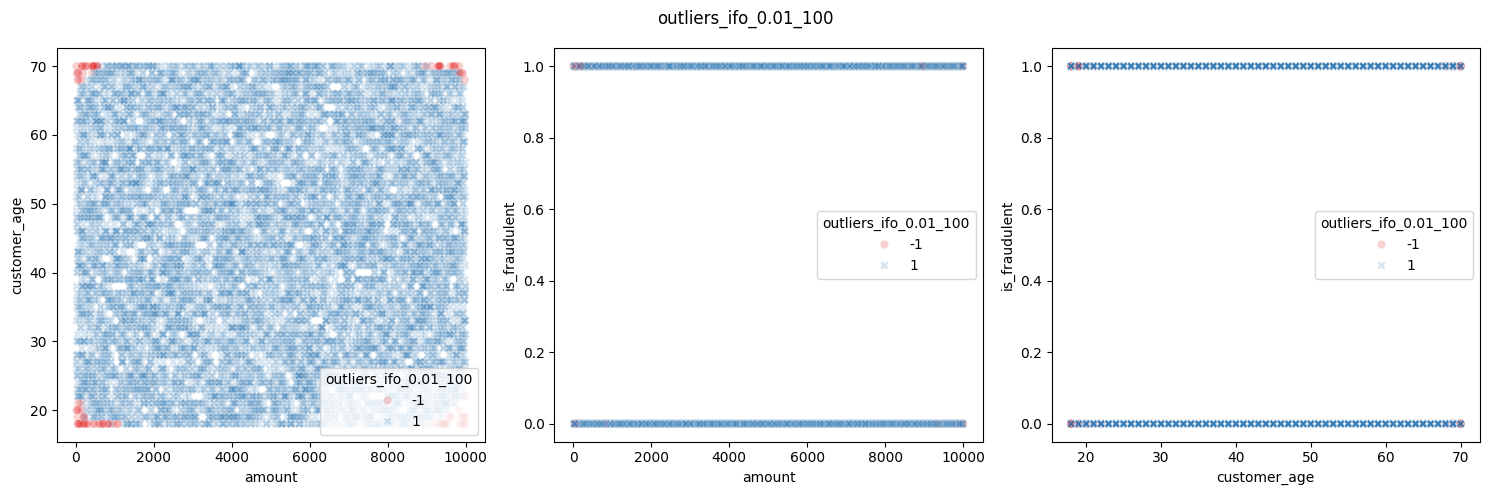

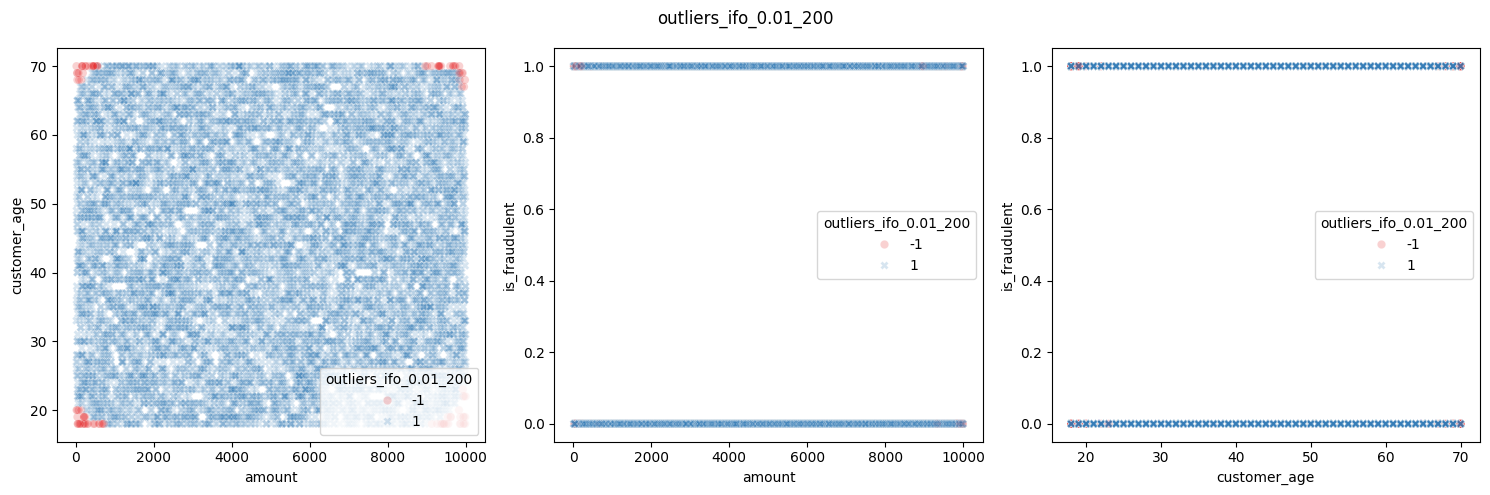

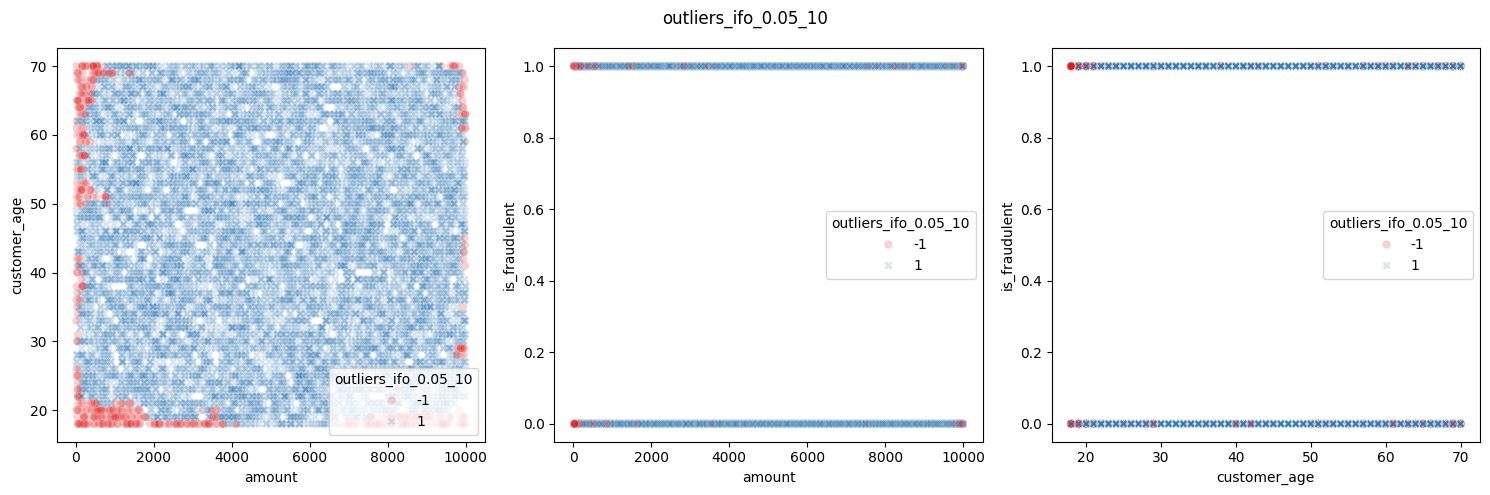

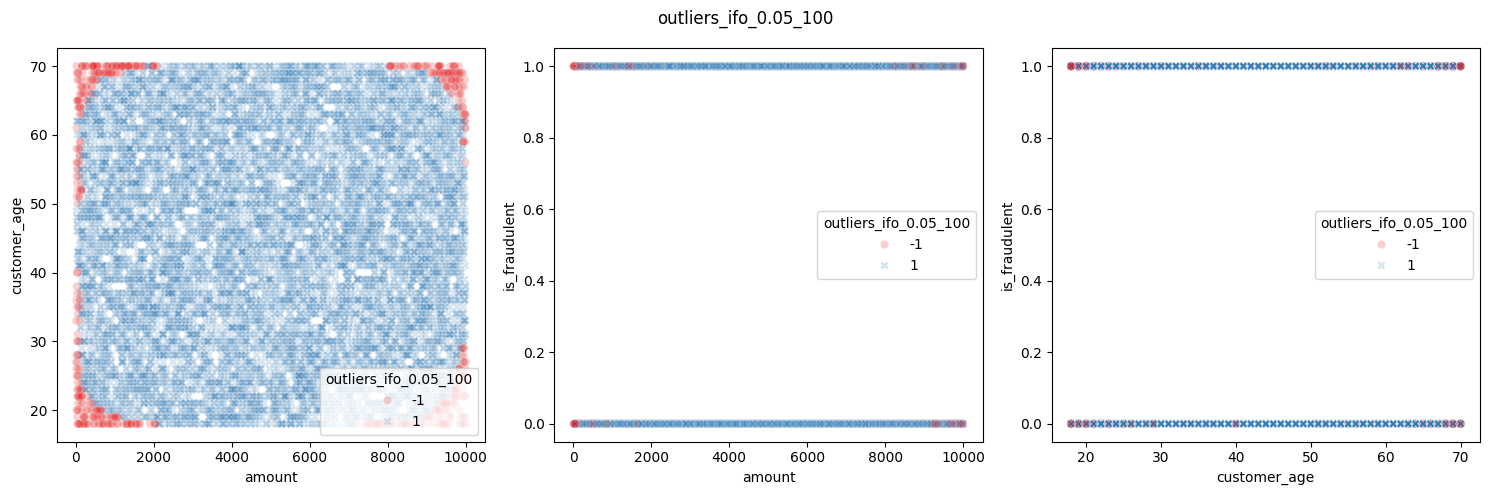

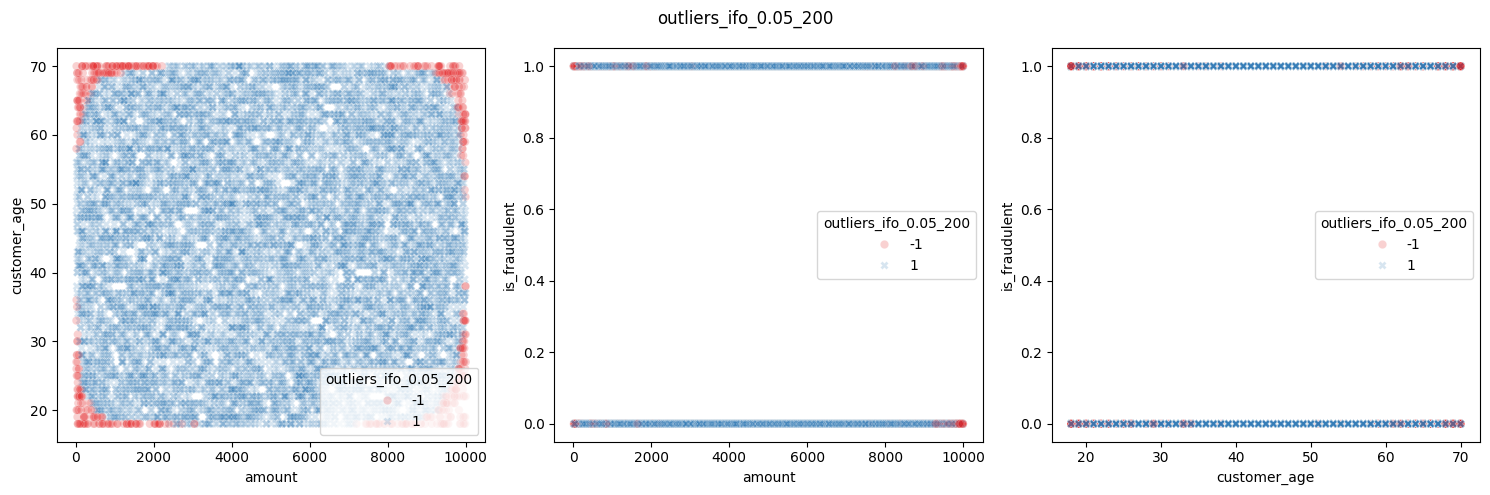

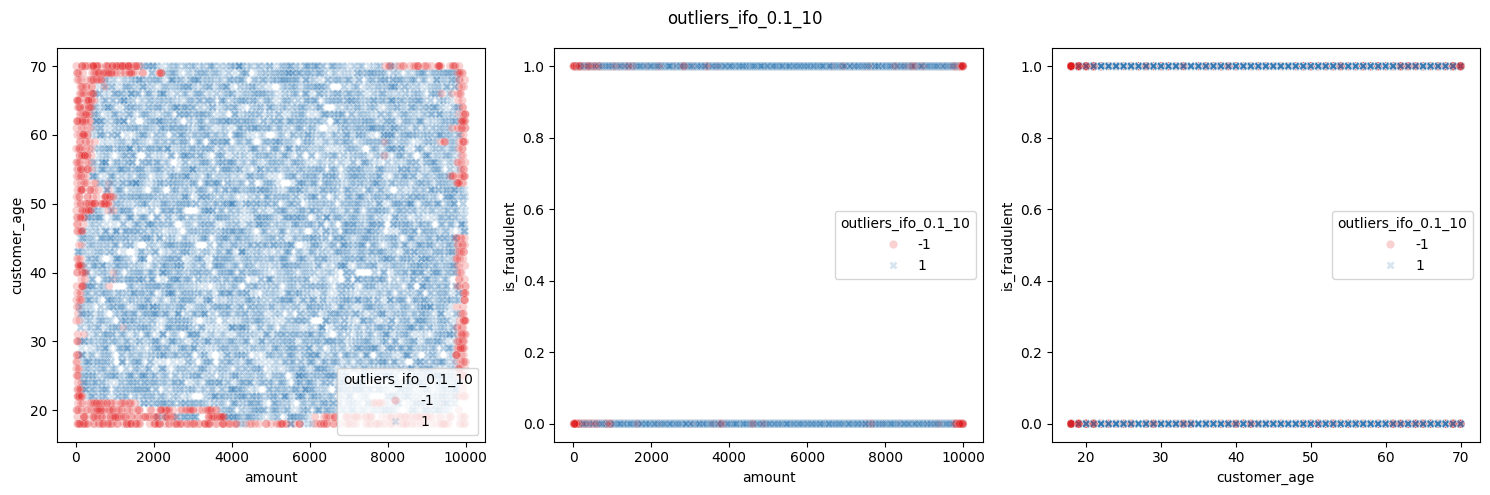

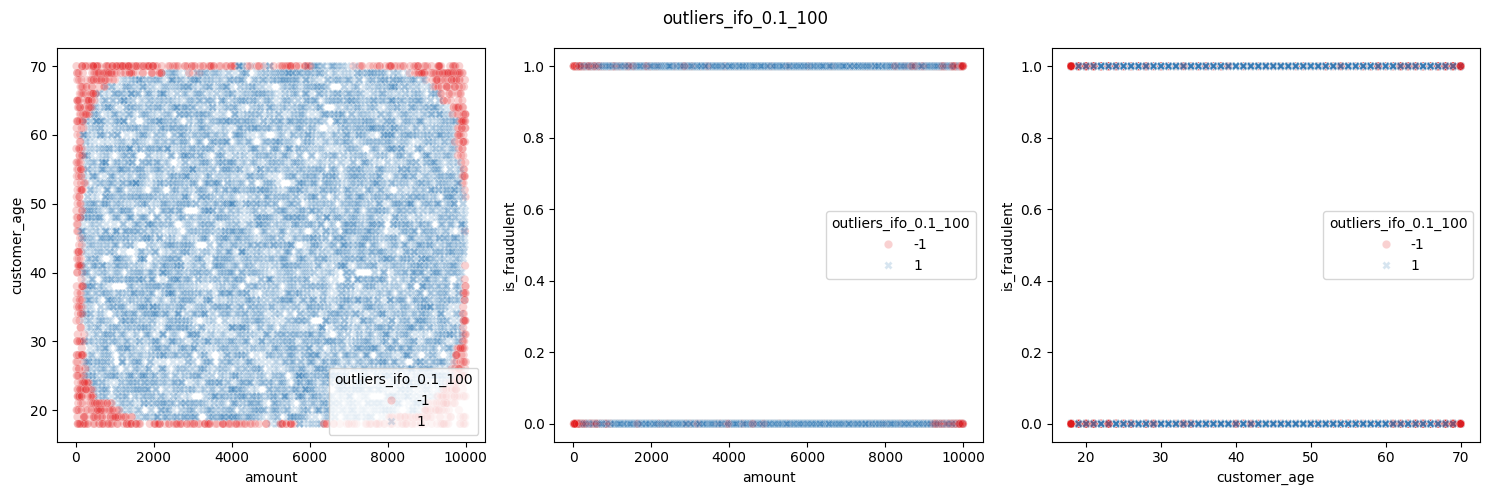

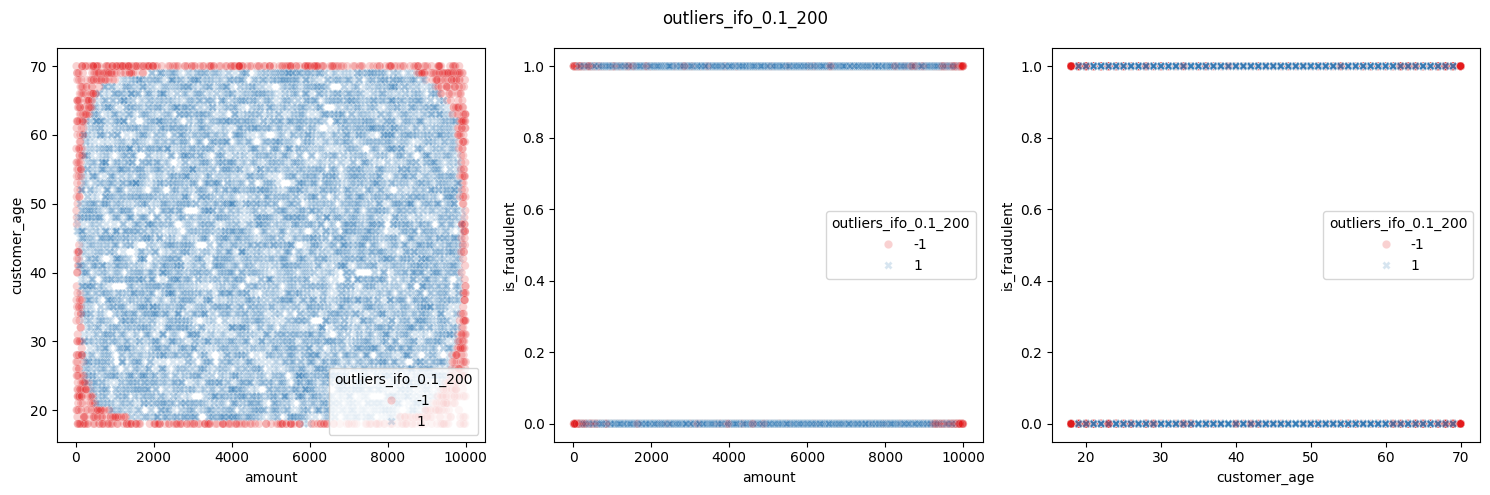

In [53]:
multi = fo.GestionOutliersMultivariados(df)

contaminacion = [0.01, 0.05, 0.1]
estimadores = [10, 100, 200]
cols = ["amount", "customer_age"]
vr = "is_fraudulent"
df_outliers = multi.detectar_outliers_if(cols, vr, contaminacion, estimadores)

In [54]:
df_outliers["porcentaje_outliers"] = df_outliers.filter(like="outliers").apply(lambda x: round(sum(x==-1)/len(x),2), axis=1)
df_outliers

is_fraudulent  customer_id  merchant_id   amount  location  \
0                0     0.540537     0.517856  5758.59  0.497382   
1                1     0.543680     0.536825  1901.56  0.529126   
2                1     0.586109     0.506026  1248.86  0.600000   
3                1     0.543680     0.525765  7619.05  0.600000   
4                1     0.470012     0.523806  1890.10  0.497382   
...            ...          ...          ...      ...       ...   
9995             1     0.534061     0.548068  8935.28  0.497608   
9996             0     0.504951     0.523362    30.15  0.481651   
9997             0     0.514017     0.451935  6333.64  0.574468   
9998             1     0.484857     0.435902  2837.13  0.537688   
9999             1     0.540537     0.546504  7209.43  0.574468   

      purchase_category  customer_age  card_type_American Express  \
0              0.524610            43                         0.0   
1              0.486978            61                         0.0   
2              0.524610            57                         0.0   
3              0.505313            59                         0.0   
4              0.513546            36                         0.0   
...                 ...           ...                         ...   
9995           0.479829            36                         0.0   
9996           0.513546            42                         0.0   
9997           0.486978            36                         1.0   
9998           0.513546            57                         0.0   
9999           0.524610            50                         0.0   

      card_type_Discover  card_type_MasterCard  ...  outliers_ifo_0.01_10  \
0                    0.0                   1.0  ...                     1   
1                    0.0                   0.0  ...                     1   
2                    0.0                   1.0  ...                     1   
3                    1.0                   0.0  ...                     1   
4                    0.0                   1.0  ...                     1   
...                  ...                   ...  ...                   ...   
9995                 0.0                   1.0  ...                     1   
9996                 0.0                   1.0  ...                     1   
9997                 0.0                   0.0  ...                     1   
9998                 0.0                   0.0  ...                     1   
9999                 1.0                   0.0  ...                     1   

      outliers_ifo_0.01_100  outliers_ifo_0.01_200  outliers_ifo_0.05_10  \
0                         1                      1                     1   
1                         1                      1                     1   
2                         1                      1                     1   
3                         1                      1                     1   
4                         1                      1                     1   
...                     ...                    ...                   ...   
9995                      1                      1                     1   
9996                      1                      1                    -1   
9997                      1                      1                     1   
9998                      1                      1                     1   
9999                      1                      1                     1   

      outliers_ifo_0.05_100  outliers_ifo_0.05_200  outliers_ifo_0.1_10  \
0                         1                      1                    1   
1                         1                      1                    1   
2                         1                      1                    1   
3                         1                      1                    1   
4                         1                      1                    1   
...                     ...                    ...                  ...   
9995    

In [55]:
porcentaje = 0.6
df_outliers_porcentaje = df_outliers[df_outliers["porcentaje_outliers"]>porcentaje]
df_restante = df_outliers[df_outliers["porcentaje_outliers"]<porcentaje]

In [56]:
df_outliers_porcentaje.shape

(271, 21)

In [59]:
print(f"Tenemos un {round(df_outliers_porcentaje.shape[0]/df_outliers.shape[0]*100, 2)}% de outliers respecto al total de los datos.")

Tenemos un 2.71% de outliers respecto al total de los datos.


Como son pocos datos por no distorsionar el df optamos por quitarlo, este punto se puede revisar y llevar a cabo otra aproximación para una próxima iteracion.

In [62]:
df_nonulls_encoded_sinout = df_restante[['is_fraudulent', 'customer_id', 'merchant_id', 'amount', 'location',
       'purchase_category', 'customer_age', 'card_type_American Express',
       'card_type_Discover', 'card_type_MasterCard', 'card_type_Visa']]

df_nonulls_encoded_sinout.reset_index(drop=True, inplace=True)

In [63]:
with open('../datos/df_nonulls_encoded_sinout.pkl', 'wb') as f:
    pickle.dump(df_nonulls_encoded_sinout, f)

__________________________

In [26]:
# col_numericas=["amount", "customer_age"]
# lista_vecinos=[5, 20, 50]
# list_contaminacion = [0.01, 0.05, 0.1]

# df_lof = df.copy()
# df_lof = multi.detectar_outliers_lof(df_lof, col_numericas, lista_vecinos, list_contaminacion)


In [27]:
# df_lof["porcentaje_outliers"] = df_lof.filter(like="outliers").apply(lambda x: round(sum(x==-1)/len(x),2), axis=1)

# porcentaje = 0.6
# df_lof_outliers_porcentaje = df_lof[df_lof["porcentaje_outliers"]>porcentaje]
# df_lof_restante = df_lof[df_lof["porcentaje_outliers"]<porcentaje]

# df_lof_outliers_porcentaje

In [28]:
# print(f"Tenemos un {round(df_lof_outliers_porcentaje.shape[0]/df_outliers.shape[0]*100, 2)}% de outliers respecto al total de los datos.")

# **Estandarizacion**

In [64]:
with open('../datos/df_nonulls_encoded_sinout.pkl', 'rb') as f:
    df = pickle.load(f)
df.head()

is_fraudulent  customer_id  merchant_id   amount  location  \
0             0     0.540537     0.517856  5758.59  0.497382   
1             1     0.543680     0.536825  1901.56  0.529126   
2             1     0.586109     0.506026  1248.86  0.600000   
3             1     0.543680     0.525765  7619.05  0.600000   
4             1     0.470012     0.523806  1890.10  0.497382   

   purchase_category  customer_age  card_type_American Express  \
0           0.524610            43                         0.0   
1           0.486978            61                         0.0   
2           0.524610            57                         0.0   
3           0.505313            59                         0.0   
4           0.513546            36                         0.0   

   card_type_Discover  card_type_MasterCard  card_type_Visa  
0                 0.0                   1.0             0.0  
1                 0.0                   0.0             1.0  
2                 0.0                   1.0             0.0  
3                 1.0                   0.0             0.0  
4                 0.0                   1.0             0.0

In [65]:
df.shape

(9729, 11)

In [69]:
pd.set_option("display.max_columns", None)
modelos_estand = ["standar", "robust", "minmax"]

df_sin_vr = df.copy()
df_sin_vr.drop(columns=["is_fraudulent"], inplace=True)
columnas_estand = ["amount", "customer_age"]

df_estand, dic_scaler = fes.estandarizacion(df_sin_vr, columnas_estand, modelos_estand)
df_estand.head()

customer_id  merchant_id   amount  location  purchase_category  \
0     0.540537     0.517856  5758.59  0.497382           0.524610   
1     0.543680     0.536825  1901.56  0.529126           0.486978   
2     0.586109     0.506026  1248.86  0.600000           0.524610   
3     0.543680     0.525765  7619.05  0.600000           0.505313   
4     0.470012     0.523806  1890.10  0.497382           0.513546   

   customer_age  card_type_American Express  card_type_Discover  \
0            43                         0.0                 0.0   
1            61                         0.0                 0.0   
2            57                         0.0                 0.0   
3            59                         0.0                 1.0   
4            36                         0.0                 0.0   

   card_type_MasterCard  card_type_Visa  amount_standar  customer_age_standar  \
0                   1.0             0.0        0.270838             -0.077579   
1                   0.0             1.0       -1.085586              1.121731   
2                   1.0             0.0       -1.315125              0.855218   
3                   0.0             0.0        0.925117              0.988474   
4                   1.0             0.0       -1.089616             -0.543977   

   amount_robust  customer_age_robust  amount_minmax  customer_age_minmax  
0       0.159942            -0.038462       0.575423             0.480769  
1      -0.621379             0.653846       0.189301             0.826923  
2      -0.753597             0.500000       0.123960             0.750000  
3       0.536816             0.576923       0.761671             0.788462  
4      -0.623701            -0.307692       0.188153             0.346154

In [70]:
df_estand.describe().T

count          mean          std        min  \
customer_id                 9729.0  5.069020e-01     0.046587   0.330059   
merchant_id                 9729.0  5.068305e-01     0.047848   0.388413   
amount                      9729.0  4.988455e+03  2843.674094  10.610000   
location                    9729.0  5.066878e-01     0.038047   0.431925   
purchase_category           9729.0  5.068183e-01     0.018232   0.479829   
customer_age                9729.0  4.416435e+01    15.009400  18.000000   
card_type_American Express  9729.0  2.496659e-01     0.432842   0.000000   
card_type_Discover          9729.0  2.640559e-01     0.440852   0.000000   
card_type_MasterCard        9729.0  2.369205e-01     0.425215   0.000000   
card_type_Visa              9729.0  2.493576e-01     0.432663   0.000000   
amount_standar              9729.0  1.163971e-16     1.000051  -1.750588   
customer_age_standar        9729.0 -1.606737e-16     1.000051  -1.743287   
amount_robust               9729.0  3.934849e-03     0.576045  -1.004430   
customer_age_robust         9729.0  6.321307e-03     0.577285  -1.000000   
amount_minmax               9729.0  4.983256e-01     0.284677   0.000000   
customer_age_minmax         9729.0  5.031607e-01     0.288642   0.000000   

                                    25%          50%          75%          max  
customer_id                    0.475736     0.505619     0.539293     0.599969  
merchant_id                    0.467296     0.505377     0.530433     0.642183  
amount                      2519.550000  4969.030000  7456.100000  9999.750000  
location                       0.481651     0.502618     0.529126     0.600000  
purchase_category              0.486978     0.513546     0.524610     0.529551  
customer_age                  31.000000    44.000000    57.000000    70.000000  
card_type_American Express     0.000000     0.000000     0.000000     1.000000  
card_type_Discover             0.000000     0.000000     1.000000     1.000000  
card_type_MasterCard           0.000000     0.000000     0.000000     1.000000  
card_type_Visa                 0.000000     0.000000     0.000000     1.000000  
amount_standar                -0.868254    -0.006831     0.867811     1.762351  
customer_age_standar          -0.877119    -0.010951     0.855218     1.721386  
amount_robust                 -0.496193     0.000000     0.503807     1.019076  
customer_age_robust           -0.500000     0.000000     0.500000     1.000000  
amount_minmax                  0.251167     0.496381     0.745358     1.000000  
customer_age_minmax            0.250000     0.500000     0.750000     1.000000

Nos quedamos con minmax ya que además de que ya no hay outliers la estandarización de min max nos da valores entre 0 y 1 que son los valores entre los cuales esta la VR por lo que parece una buena aproximación para esta primera iteración.

In [73]:
df_minmax = df_estand[['customer_id', 'merchant_id', 'location', 'purchase_category',
        'card_type_American Express', 'card_type_Discover',
       'card_type_MasterCard', 'card_type_Visa',
       'amount_minmax', 'customer_age_minmax']]
df_minmax["is_fraudulent"] = df["is_fraudulent"]
df_minmax

customer_id  merchant_id  location  purchase_category  \
0        0.540537     0.517856  0.497382           0.524610   
1        0.543680     0.536825  0.529126           0.486978   
2        0.586109     0.506026  0.600000           0.524610   
3        0.543680     0.525765  0.600000           0.505313   
4        0.470012     0.523806  0.497382           0.513546   
...           ...          ...       ...                ...   
9724     0.534061     0.548068  0.497608           0.479829   
9725     0.504951     0.523362  0.481651           0.513546   
9726     0.514017     0.451935  0.574468           0.486978   
9727     0.484857     0.435902  0.537688           0.513546   
9728     0.540537     0.546504  0.574468           0.524610   

      card_type_American Express  card_type_Discover  card_type_MasterCard  \
0                            0.0                 0.0                   1.0   
1                            0.0                 0.0                   0.0   
2                            0.0                 0.0                   1.0   
3                            0.0                 1.0                   0.0   
4                            0.0                 0.0                   1.0   
...                          ...                 ...                   ...   
9724                         0.0                 0.0                   1.0   
9725                         0.0                 0.0                   1.0   
9726                         1.0                 0.0                   0.0   
9727                         0.0                 0.0                   0.0   
9728                         0.0                 1.0                   0.0   

      card_type_Visa  amount_minmax  customer_age_minmax is_fraudulent  
0                0.0       0.575423             0.480769             0  
1                1.0       0.189301             0.826923             1  
2                0.0       0.123960             0.750000             1  
3                0.0       0.761671             0.788462             1  
4                0.0       0.188153             0.346154             1  
...              ...            ...                  ...           ...  
9724             0.0       0.893437             0.346154             1  
9725             0.0       0.001956             0.461538             0  
9726             0.0       0.632990             0.346154             0  
9727             1.0       0.282959             0.750000             1  
9728             0.0       0.720665             0.615385             1  

[9729 rows x 11 columns]

In [74]:
with open('../datos/df_nonulls_encoded_sinout_estand.pkl', 'wb') as f:
    pickle.dump(df_minmax, f)